## Analysis of Survey Data for AI vs. Human-Generated Messages


#### Load Modules

In [1]:
import sys, os
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import pandas as pd
%matplotlib inline
import seaborn as sns
import numpy as np
sns.set_style("ticks")


#### Load and inspect data

In [2]:
df = pd.read_csv('../../data/V2_uae_survey_cleaned_reversed_reduced_avg_errorcorrected.csv')
df.head(3)

,Duration (in seconds),Finished,UserLanguage,clarity_ai_mw_01_1,clarity_ai_mw_02_1,clarity_ai_mw_03_1,clarity_ai_mw_04_1,clarity_ai_mw_05_1,clarity_ai_wd_01_1,clarity_ai_wd_02_1,...,woman_binary,nationality,migrant_binary,work,work_binary,car_driving,driving_binary,women_driver_status,migrant_worker_status,young_driver_status
0,300.0,1.0,EN,2.0,3.0,5.0,5.0,5.0,4.0,5.0,...,1.0,UAE,0.0,student,0.0,0.25,1.0,1.0,0.0,1.0
1,309.0,1.0,EN,3.0,4.0,3.0,4.0,3.0,4.0,3.0,...,1.0,non-UAE,1.0,job,1.0,13.00,1.0,1.0,1.0,0.0
2,312.0,1.0,EN,4.0,5.0,4.0,4.0,4.0,5.0,5.0,...,1.0,UAE,0.0,student,0.0,-99.00,0.0,0.0,0.0,0.0


In [3]:
df.describe()

,Duration (in seconds),Finished,clarity_ai_mw_01_1,clarity_ai_mw_02_1,clarity_ai_mw_03_1,clarity_ai_mw_04_1,clarity_ai_mw_05_1,clarity_ai_wd_01_1,clarity_ai_wd_02_1,clarity_ai_wd_03_1,...,young_binary,gender_1man_2woman,woman_binary,migrant_binary,work_binary,car_driving,driving_binary,women_driver_status,migrant_worker_status,young_driver_status
count,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,...,185.000000,177.000000,127.0,186.00000,186.000000,162.000000,164.000000,187.000000,187.000000,187.000000
mean,5816.774194,0.946237,4.139785,3.951613,4.026882,3.822581,3.908602,3.956989,3.908602,3.731183,...,0.513514,1.728814,1.0,0.50000,0.467742,-14.325309,0.804878,0.930481,0.363636,0.695187
std,45831.557279,0.226159,1.222239,1.222679,1.169120,1.313434,1.246500,1.264176,1.334463,1.266105,...,0.501174,0.458400,0.0,0.50135,0.500305,39.897474,0.397508,6.347507,2.502980,4.751698
min,300.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,1.000000,1.0,0.00000,0.000000,-99.000000,0.000000,0.000000,0.000000,0.000000
25%,499.750000,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,0.000000,1.000000,1.0,0.00000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,711.000000,1.000000,5.000000,4.000000,4.000000,4.000000,4.000000,4.500000,4.500000,4.000000,...,1.000000,2.000000,1.0,0.50000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000
75%,1020.500000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,1.000000,2.000000,1.0,1.00000,1.000000,4.000000,1.000000,1.000000,0.000000,1.000000
max,604947.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,1.000000,3.000000,1.0,1.00000,1.000000,30.000000,1.000000,87.000000,34.000000,65.000000


### Analysis of Audience Matching

#### First, the stats

In [4]:
to_evaluate = [['clarity_hum_mw','clarity_ai_mw', 'quality_hum_mw','quality_ai_mw'],
               ['clarity_hum_wd','clarity_ai_wd', 'quality_hum_wd','quality_ai_wd'],
               ['clarity_hum_yd','clarity_ai_yd', 'quality_hum_yd','quality_ai_yd']]

group_variable = ['migrant_worker_status',
                  'women_driver_status',
                  'young_driver_status']


def run_ttest(to_evaluate_variable, grouping_variable):
    values = df.filter(regex  = to_evaluate_variable,axis=1).mean(axis=1).values
    values_target_audience    =  values[df[grouping_variable].values == 1]
    values_nontarget_audience =  values[df[grouping_variable].values == 0]    

    values_target_audience = values_target_audience[~np.isnan(values_target_audience)]
    values_nontarget_audience = values_nontarget_audience[~np.isnan(values_nontarget_audience)]

    (t, p) = scipy.stats.ttest_ind(values_target_audience, values_nontarget_audience, alternative = 'greater')
    return to_evaluate_variable + ' by ' +  grouping_variable + ': t-value = ' + str(round(t, 2)) + ', p = ' + str(round(p, 2))


for current_group_index in range(3):
    for current_evaluation_index in range(4):
        print(run_ttest(to_evaluate[current_group_index][current_evaluation_index], group_variable[current_group_index]))
    print(' ')

clarity_hum_mw by migrant_worker_status: t-value = -1.7, p = 0.95
clarity_ai_mw by migrant_worker_status: t-value = -2.61, p = 1.0
quality_hum_mw by migrant_worker_status: t-value = -2.92, p = 1.0
quality_ai_mw by migrant_worker_status: t-value = -2.53, p = 0.99
 
clarity_hum_wd by women_driver_status: t-value = -0.11, p = 0.54
clarity_ai_wd by women_driver_status: t-value = -0.42, p = 0.66
quality_hum_wd by women_driver_status: t-value = -2.09, p = 0.98
quality_ai_wd by women_driver_status: t-value = -0.77, p = 0.78
 
clarity_hum_yd by young_driver_status: t-value = 0.79, p = 0.22
clarity_ai_yd by young_driver_status: t-value = 1.9, p = 0.03
quality_hum_yd by young_driver_status: t-value = 2.24, p = 0.01
quality_ai_yd by young_driver_status: t-value = 2.09, p = 0.02
 


#### Second, plotting everything

Migrant Workers:
34 matching &  152 nonmatching target
Women Drivers:
87 matching &  99 nonmatching target
Young Drivers:
65 matching &  121 nonmatching target


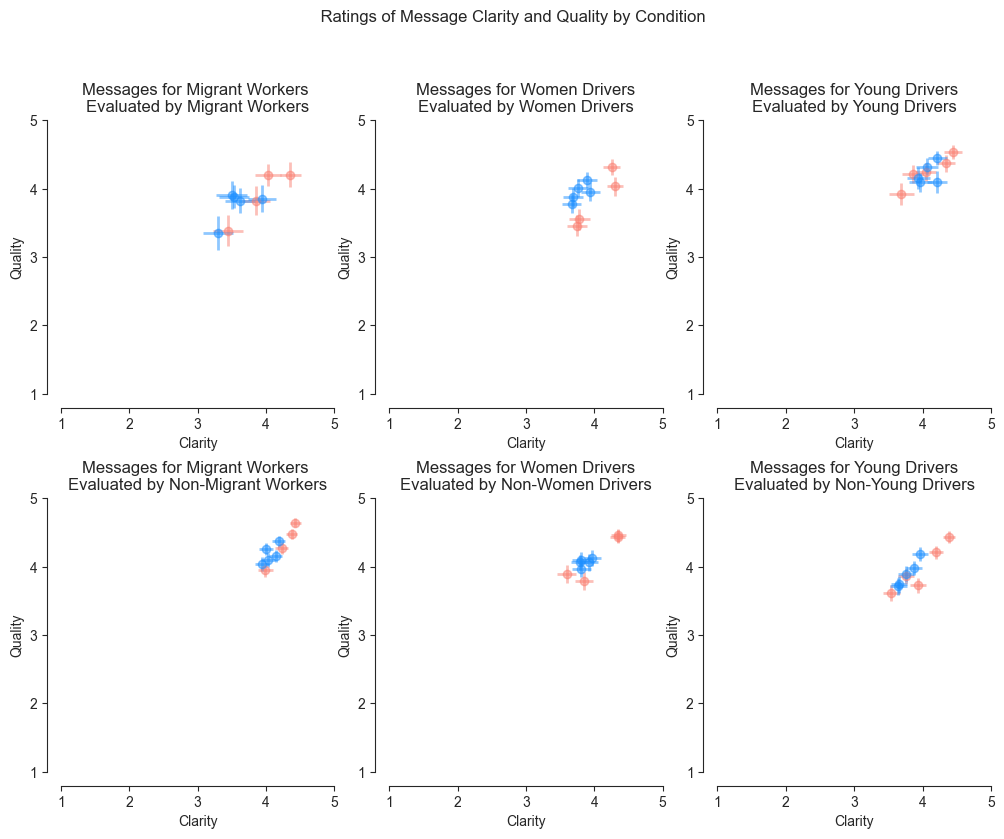

In [5]:
fig = plt.figure(figsize = (12, 9))
plt.suptitle(" Ratings of Message Clarity and Quality by Condition")

# Migrant worker messages
print('Migrant Workers:')
df_target = df[df['migrant_worker_status'] == 1]
df_nontarget = df[df['migrant_worker_status'] == 0]
print( str(len(df_target)) + ' matching &  ' + str(len(df_nontarget))  + ' nonmatching target')

# target audience
ax1 = fig.add_subplot(231)
ax1.title.set_text('Messages for Migrant Workers \nEvaluated by Migrant Workers')
plt.errorbar( y = df_target.filter(regex = 'quality_hum_mw',axis=1).mean().values,  
              x = df_target.filter(regex = 'clarity_hum_mw',axis=1).mean().values,
              yerr = df_target.filter(regex = 'quality_hum_mw',axis=1).std(axis=0)/np.sqrt(len(df_target)), 
              xerr = df_target.filter(regex = 'clarity_hum_mw',axis=1).std(axis=0)/np.sqrt(len(df_target)),
              c = 'salmon', linewidth = 0, fmt='o',
              ecolor='salmon', elinewidth=2, alpha = 0.5,  capsize=0 );

plt.errorbar( y = df_target.filter(regex = 'quality_ai_mw',axis=1).mean().values,  
              x = df_target.filter(regex = 'clarity_ai_mw',axis=1).mean().values,
              yerr = df_target.filter(regex = 'quality_ai_mw',axis=1).std(axis=0)/np.sqrt(len(df_target)), 
              xerr = df_target.filter(regex = 'clarity_ai_mw',axis=1).std(axis=0)/np.sqrt(len(df_target)),
              c = 'dodgerblue', linewidth = 0, fmt='o',
              ecolor='dodgerblue', elinewidth=2, alpha = 0.5,  capsize=0 );
plt.axis('square'); plt.ylim(1,5); plt.xlim(1,5); plt.xticks(np.arange(1,6)); plt.yticks(np.arange(1,6)); plt.xlabel('Clarity'); plt.ylabel('Quality'); 

# nontarget audience
ax4 = fig.add_subplot(234)
ax4.title.set_text('Messages for Migrant Workers \nEvaluated by Non-Migrant Workers')
plt.errorbar( y = df_nontarget.filter(regex = 'quality_hum_mw',axis=1).mean().values,  
              x = df_nontarget.filter(regex = 'clarity_hum_mw',axis=1).mean().values,
              yerr = df_nontarget.filter(regex = 'quality_hum_mw',axis=1).std(axis=0)/np.sqrt(len(df_nontarget)), 
              xerr = df_nontarget.filter(regex = 'clarity_hum_mw',axis=1).std(axis=0)/np.sqrt(len(df_nontarget)),
              c = 'salmon', linewidth = 0, fmt='o',
              ecolor='salmon', elinewidth=2, alpha = 0.5,  capsize=0 );

plt.errorbar( y = df_nontarget.filter(regex = 'quality_ai_mw',axis=1).mean().values,  
              x = df_nontarget.filter(regex = 'clarity_ai_mw',axis=1).mean().values,
              yerr = df_nontarget.filter(regex = 'quality_ai_mw',axis=1).std(axis=0)/np.sqrt(len(df_nontarget)), 
              xerr = df_nontarget.filter(regex = 'clarity_ai_mw',axis=1).std(axis=0)/np.sqrt(len(df_nontarget)),
              c = 'dodgerblue', linewidth = 0, fmt='o',
              ecolor='dodgerblue', elinewidth=2, alpha = 0.5,  capsize=0 );
plt.axis('square'); plt.ylim(1,5); plt.xlim(1,5); plt.xticks(np.arange(1,6)); plt.yticks(np.arange(1,6)); plt.xlabel('Clarity'); plt.ylabel('Quality'); 


# Women driver messages
print('Women Drivers:')
df_target = df[df['women_driver_status'] == 1]
df_nontarget = df[df['women_driver_status'] == 0]
print( str(len(df_target)) + ' matching &  ' + str(len(df_nontarget))  + ' nonmatching target')

# target audience
ax2 = fig.add_subplot(232)
ax2.title.set_text('Messages for Women Drivers\nEvaluated by Women Drivers')
plt.errorbar( y = df_target.filter(regex = 'quality_hum_wd',axis=1).mean().values,  
              x = df_target.filter(regex = 'clarity_hum_wd',axis=1).mean().values,
              yerr = df_target.filter(regex = 'quality_hum_wd',axis=1).std(axis=0)/np.sqrt(len(df_target)), 
              xerr = df_target.filter(regex = 'clarity_hum_wd',axis=1).std(axis=0)/np.sqrt(len(df_target)),
              c = 'salmon', linewidth = 0, fmt='o',
              ecolor='salmon', elinewidth=2, alpha = 0.5,  capsize=0 );

plt.errorbar( y = df_target.filter(regex = 'quality_ai_wd',axis=1).mean().values,  
              x = df_target.filter(regex = 'clarity_ai_wd',axis=1).mean().values,
              yerr = df_target.filter(regex = 'quality_ai_wd',axis=1).std(axis=0)/np.sqrt(len(df_target)), 
              xerr = df_target.filter(regex = 'clarity_ai_wd',axis=1).std(axis=0)/np.sqrt(len(df_target)),
              c = 'dodgerblue', linewidth = 0, fmt='o',
              ecolor='dodgerblue', elinewidth=2, alpha = 0.5,  capsize=0 );
plt.axis('square'); plt.ylim(1,5); plt.xlim(1,5); plt.xticks(np.arange(1,6)); plt.yticks(np.arange(1,6)); plt.xlabel('Clarity'); plt.ylabel('Quality'); 

#nontarget audience
ax5 = fig.add_subplot(235)
ax5.title.set_text('Messages for Women Drivers\nEvaluated by Non-Women Drivers')
plt.errorbar( y = df_nontarget.filter(regex = 'quality_hum_wd',axis=1).mean().values,  
              x = df_nontarget.filter(regex = 'clarity_hum_wd',axis=1).mean().values,
              yerr = df_nontarget.filter(regex = 'quality_hum_wd',axis=1).std(axis=0)/np.sqrt(len(df_nontarget)), 
              xerr = df_nontarget.filter(regex = 'clarity_hum_wd',axis=1).std(axis=0)/np.sqrt(len(df_nontarget)),
              c = 'salmon', linewidth = 0, fmt='o',
              ecolor='salmon', elinewidth=2, alpha = 0.5,  capsize=0 );

plt.errorbar( y = df_nontarget.filter(regex = 'quality_ai_wd',axis=1).mean().values,  
              x = df_nontarget.filter(regex = 'clarity_ai_wd',axis=1).mean().values,
              yerr = df_nontarget.filter(regex = 'quality_ai_wd',axis=1).std(axis=0)/np.sqrt(len(df_nontarget)), 
              xerr = df_nontarget.filter(regex = 'clarity_ai_wd',axis=1).std(axis=0)/np.sqrt(len(df_nontarget)),
              c = 'dodgerblue', linewidth = 0, fmt='o',
              ecolor='dodgerblue', elinewidth=2, alpha = 0.5,  capsize=0 );
plt.axis('square'); plt.ylim(1,5); plt.xlim(1,5); plt.xticks(np.arange(1,6)); plt.yticks(np.arange(1,6)); plt.xlabel('Clarity'); plt.ylabel('Quality'); 


# Young driver messages
print('Young Drivers:')
df_target = df[df['young_driver_status'] == 1]
df_nontarget = df[df['young_driver_status'] == 0]
print( str(len(df_target)) + ' matching &  ' + str(len(df_nontarget))  + ' nonmatching target')

# target audience
ax3 = fig.add_subplot(233)
ax3.title.set_text('Messages for Young Drivers\nEvaluated by Young Drivers')
plt.errorbar( y = df_target.filter(regex = 'quality_hum_yd',axis=1).mean().values,  
              x = df_target.filter(regex = 'clarity_hum_yd',axis=1).mean().values,
              yerr = df_target.filter(regex = 'quality_hum_yd',axis=1).std(axis=0)/np.sqrt(len(df_target)), 
              xerr = df_target.filter(regex = 'clarity_hum_yd',axis=1).std(axis=0)/np.sqrt(len(df_target)),
              c = 'salmon', linewidth = 0, fmt='o',
              ecolor='salmon', elinewidth=2, alpha = 0.5,  capsize=0 );

plt.errorbar( y = df_target.filter(regex = 'quality_ai_yd',axis=1).mean().values,  
              x = df_target.filter(regex = 'clarity_ai_yd',axis=1).mean().values,
              yerr = df_target.filter(regex = 'quality_ai_yd',axis=1).std(axis=0)/np.sqrt(len(df_target)), 
              xerr = df_target.filter(regex = 'clarity_ai_yd',axis=1).std(axis=0)/np.sqrt(len(df_target)),
              c = 'dodgerblue', linewidth = 0, fmt='o',
              ecolor='dodgerblue', elinewidth=2, alpha = 0.5,  capsize=0 );
plt.axis('square'); plt.ylim(1,5); plt.xlim(1,5); plt.xticks(np.arange(1,6)); plt.yticks(np.arange(1,6)); plt.xlabel('Clarity'); plt.ylabel('Quality'); 

# nontarget audience
ax6 = fig.add_subplot(236)
ax6.title.set_text('Messages for Young Drivers\nEvaluated by Non-Young Drivers')
plt.errorbar( y = df_nontarget.filter(regex = 'quality_hum_yd',axis=1).mean().values,  
              x = df_nontarget.filter(regex = 'clarity_hum_yd',axis=1).mean().values,
              yerr = df_nontarget.filter(regex = 'quality_hum_yd',axis=1).std(axis=0)/np.sqrt(len(df_nontarget)), 
              xerr = df_nontarget.filter(regex = 'clarity_hum_yd',axis=1).std(axis=0)/np.sqrt(len(df_nontarget)),
              c = 'salmon', linewidth = 0, fmt='o',
              ecolor='salmon', elinewidth=2, alpha = 0.5,  capsize=0 );

plt.errorbar( y = df_nontarget.filter(regex = 'quality_ai_yd',axis=1).mean().values,  
              x = df_nontarget.filter(regex = 'clarity_ai_yd',axis=1).mean().values,
              yerr = df_nontarget.filter(regex = 'quality_ai_yd',axis=1).std(axis=0)/np.sqrt(len(df_nontarget)), 
              xerr = df_nontarget.filter(regex = 'clarity_ai_yd',axis=1).std(axis=0)/np.sqrt(len(df_nontarget)),
              c = 'dodgerblue', linewidth = 0, fmt='o',
              ecolor='dodgerblue', elinewidth=2, alpha = 0.5,  capsize=0 );
plt.axis('square'); plt.ylim(1,5); plt.xlim(1,5); plt.xticks(np.arange(1,6)); plt.yticks(np.arange(1,6)); plt.xlabel('Clarity'); plt.ylabel('Quality'); 


sns.despine(offset=10, trim=True);

In [22]:
#'''
df_audience_themes = pd.DataFrame()

df_audience_themes['mw_hum_average_clarity']= df.filter(regex = 'clarity_hum_mw',axis=1).mean(axis=1)
df_audience_themes['mw_status'] = df['migrant_worker_status'].values

df_audience_themes['wd_hum_average_clarity']= df.filter(regex = 'clarity_hum_wd',axis=1).mean(axis=1)
df_audience_themes['wd_status'] = df['women_driver_status'].values

df_audience_themes['yd_hum_average_clarity']= df.filter(regex = 'clarity_hum_yd',axis=1).mean(axis=1)
df_audience_themes['yd_status'] = df['young_driver_status'].values

df_audience_themes.head()#'''

,mw_hum_average_clarity,mw_status,wd_hum_average_clarity,wd_status,yd_hum_average_clarity,yd_status
0,5.0,0.0,4.75,1.0,4.8,1.0
1,4.2,1.0,4.00,1.0,3.4,0.0
2,4.4,0.0,4.25,0.0,4.0,0.0
3,4.6,0.0,4.75,1.0,5.0,1.0
4,5.0,0.0,5.00,0.0,5.0,0.0



### reshape DF and prepare for analysis by subjects, items


In [23]:
def convert_to_sub_pattern(num):
    return f'sub{str(num + 1).zfill(3)}'

In [24]:
# quality first
sub_df = df.filter(regex = 'quali',axis=1)
sub_df.reset_index(inplace=True)
sub_df = sub_df.rename(columns={'index': 'index_col'}).copy()
sub_df['sub_index'] = sub_df['index_col'].map(convert_to_sub_pattern)
sub_df = sub_df.drop('index_col', axis=1)

melted_df = pd.melt(sub_df, id_vars=['sub_index'], var_name='all_messages', value_name='message_evaluation')
sorted_melted_df = melted_df.sort_values(by='sub_index') 

sorted_melted_df['source'] = 'No'  # Initialize with default value
sorted_melted_df.loc[sorted_melted_df['all_messages'].str.contains('_ai_'), 'source'] = 'AI'
sorted_melted_df.loc[sorted_melted_df['all_messages'].str.contains('_hum_'), 'source'] = 'Human'

sorted_melted_df['theme'] = 'No'  
sorted_melted_df.loc[sorted_melted_df['all_messages'].str.contains('_mw_'), 'theme'] = 'Migrant Workers'
sorted_melted_df.loc[sorted_melted_df['all_messages'].str.contains('_wd_'), 'theme'] = 'Women Drivers'
sorted_melted_df.loc[sorted_melted_df['all_messages'].str.contains('_yd_'), 'theme'] = 'Young Drivers'

sorted_melted_df = sorted_melted_df.sort_values(by=['sub_index', 'all_messages'], ascending=[True, True])
desired_order = ['sub_index', 'source', 'theme', 'all_messages', 'message_evaluation']  # Specify the desired column order
sorted_melted_df = sorted_melted_df[desired_order]
sorted_melted_df.reset_index(inplace=True)

sorted_melted_df

,index,sub_index,source,theme,all_messages,message_evaluation
0,0,sub001,AI,Migrant Workers,quality_ai_mw_01_1,5.0
1,188,sub001,AI,Migrant Workers,quality_ai_mw_02_1,5.0
2,376,sub001,AI,Migrant Workers,quality_ai_mw_03_1,5.0
3,564,sub001,AI,Migrant Workers,quality_ai_mw_04_1,4.0
4,752,sub001,AI,Migrant Workers,quality_ai_mw_05_1,4.0
...,...,...,...,...,...,...
5635,4887,sub188,Human,Young Drivers,quality_hum_yd_01_1,NaN
5636,5075,sub188,Human,Young Drivers,quality_hum_yd_02_1,NaN
5637,5263,sub188,Human,Young Drivers,quality_hum_yd_03_1,NaN
5638,5451,sub188,Human,Young Drivers,quality_hum_yd_04_1,NaN


In [11]:
# clarity second
sub_df = df.filter(regex = 'clari',axis=1)
sub_df.reset_index(inplace=True)
sub_df = sub_df.rename(columns={'index': 'index_col'}).copy()
sub_df['sub_index'] = sub_df['index_col'].map(convert_to_sub_pattern)
sub_df = sub_df.drop('index_col', axis=1)

melted_df = pd.melt(sub_df, id_vars=['sub_index'], var_name='all_messages', value_name='message_evaluation')
sorted_melted_df = melted_df.sort_values(by='sub_index') 

sorted_melted_df['source'] = 'No'  # Initialize with default value
sorted_melted_df.loc[sorted_melted_df['all_messages'].str.contains('_ai_'), 'source'] = 'AI'
sorted_melted_df.loc[sorted_melted_df['all_messages'].str.contains('_hum_'), 'source'] = 'Human'

sorted_melted_df['theme'] = 'No'  
sorted_melted_df.loc[sorted_melted_df['all_messages'].str.contains('_mw_'), 'theme'] = 'Migrant Workers'
sorted_melted_df.loc[sorted_melted_df['all_messages'].str.contains('_wd_'), 'theme'] = 'Women Drivers'
sorted_melted_df.loc[sorted_melted_df['all_messages'].str.contains('_yd_'), 'theme'] = 'Young Drivers'

sorted_melted_df = sorted_melted_df.sort_values(by=['sub_index', 'all_messages'], ascending=[True, True])
desired_order = ['sub_index', 'source', 'theme', 'all_messages', 'message_evaluation']  # Specify the desired column order
sorted_melted_df = sorted_melted_df[desired_order]
sorted_melted_df.reset_index(inplace=True)

sorted_melted_df

,index,sub_index,source,theme,all_messages,message_evaluation
0,0,sub001,AI,Migrant Workers,clarity_ai_mw_01_1,2.0
1,188,sub001,AI,Migrant Workers,clarity_ai_mw_02_1,3.0
2,376,sub001,AI,Migrant Workers,clarity_ai_mw_03_1,5.0
3,564,sub001,AI,Migrant Workers,clarity_ai_mw_04_1,5.0
4,752,sub001,AI,Migrant Workers,clarity_ai_mw_05_1,5.0
...,...,...,...,...,...,...
5635,4887,sub188,Human,Young Drivers,clarity_hum_yd_01_1,NaN
5636,5075,sub188,Human,Young Drivers,clarity_hum_yd_02_1,NaN
5637,5263,sub188,Human,Young Drivers,clarity_hum_yd_03_1,NaN
5638,5451,sub188,Human,Young Drivers,clarity_hum_yd_04_1,NaN
